### IMPORT

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns


### VERİ YÜKLEME

In [51]:
df = pd.read_csv("C:\\Users\\merve\\Desktop\\staj_lotus_ai\\EtSut_ML_Projects\\05_anomaly_milk_sensor\\data\\milk_mir_traits_data.csv")
print(df.shape)
df.head()

(431, 582)


,Breed,Date_of_sampling,Parity,Milking_Time,DaysInMilk,Protein_content,kappa_casein,alpha_s2_casein,alpha_s1_casein,beta_casein,...,3788,3791,3795,3799,3803,3807,3811,3815,3818,3822
0,Hol Fri,20/08/2013,5.0,1.0,197.0,3.35,5.30620,3.129512,12.09580,9.70916,...,0.028741,0.029182,0.029620,0.030060,0.030488,0.030874,0.031192,0.031433,0.031607,0.031742
1,Hol Fri,20/08/2013,5.0,1.0,203.0,3.48,6.10762,3.722658,12.63136,11.07848,...,0.012581,0.013158,0.013705,0.014237,0.014758,0.015258,0.015720,0.016129,0.016478,0.016773
2,JEX-,20/08/2013,5.0,1.0,193.0,3.61,7.05540,0.657284,12.47792,11.48780,...,0.027213,0.027730,0.028210,0.028658,0.029079,0.029473,0.029837,0.030162,0.030445,0.030686
3,FRX-,20/08/2013,4.0,1.0,119.0,3.64,8.28818,6.145520,21.83550,17.22150,...,0.035717,0.036143,0.036553,0.036960,0.037364,0.037747,0.038090,0.038380,0.038615,0.038807
4,JEX-,20/08/2013,5.0,1.0,206.0,4.20,7.30404,4.022390,16.78622,14.34638,...,0.020784,0.021316,0.021844,0.022381,0.022926,0.023459,0.023956,0.024391,0.024753,0.025048


### KEŞİFÇİ VERİ ANALİZİ

In [5]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

##################### Shape #####################
(431, 582)
##################### Types #####################
Breed                object
Date_of_sampling     object
Parity              float64
Milking_Time        float64
DaysInMilk          float64
                     ...   
3807                float64
3811                float64
3815                float64
3818                float64
3822                float64
Length: 582, dtype: object
##################### Head #####################
     Breed Date_of_sampling  Parity  Milking_Time  DaysInMilk  \
0  Hol Fri       20/08/2013     5.0           1.0       197.0   
1  Hol Fri       20/08/2013     5.0           1.0       203.0   
2     JEX-       20/08/2013     5.0           1.0       193.0   

   Protein_content  kappa_casein  alpha_s2_casein  alpha_s1_casein  \
0             3.35       5.30620         3.129512         12.09580   
1             3.48       6.10762         3.722658         12.63136   
2             3.61       7.05540  

In [15]:
df.isnull().sum()

Breed               1
Date_of_sampling    0
Parity              1
Milking_Time        1
DaysInMilk          1
                   ..
3807                0
3811                0
3815                0
3818                0
3822                0
Length: 582, dtype: int64

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols

In [16]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)    

Observations: 431
Variables: 582
cat_cols: 5
num_cols: 576
cat_but_car: 1
num_but_cat: 4


#### Korelasyon analizinde çok fazla değişken olduğu için sayısal olarak analiz ettik 

In [10]:
corr = df[num_cols].corr()
corr

,Parity,DaysInMilk,Protein_content,kappa_casein,alpha_s2_casein,alpha_s1_casein,beta_casein,alpha_lactalbumin,beta_lactoglobulin_a,beta_lactoglobulin_b,...,3788,3791,3795,3799,3803,3807,3811,3815,3818,3822
Parity,1.000000,-0.007392,-0.010775,-0.036461,0.092303,-0.099823,-0.186341,-0.002749,-0.108229,0.008731,...,0.034341,0.034480,0.034581,0.034660,0.034739,0.034838,0.034967,0.035117,0.035265,0.035377
DaysInMilk,-0.007392,1.000000,0.501368,0.377559,0.297249,0.387838,0.375923,0.205848,0.352774,0.229843,...,-0.011661,-0.011961,-0.012067,-0.011912,-0.011496,-0.010896,-0.010247,-0.009695,-0.009348,-0.009245
Protein_content,-0.010775,0.501368,1.000000,0.540133,0.473544,0.625027,0.563914,0.183213,0.370135,0.196128,...,-0.005891,-0.004542,-0.003091,-0.001453,0.000374,0.002304,0.004192,0.005893,0.007322,0.008477
kappa_casein,-0.036461,0.377559,0.540133,1.000000,0.601168,0.791260,0.766591,0.266582,0.527511,0.316418,...,-0.138999,-0.138038,-0.137003,-0.135804,-0.134424,-0.132932,-0.131449,-0.130094,-0.128940,-0.127994
alpha_s2_casein,0.092303,0.297249,0.473544,0.601168,1.000000,0.645542,0.623708,0.192880,0.350200,0.232276,...,-0.207421,-0.206161,-0.204777,-0.203178,-0.201394,-0.199561,-0.197855,-0.196417,-0.195281,-0.194371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3807,0.034838,-0.010896,0.002304,-0.132932,-0.199561,-0.033025,-0.112296,-0.005479,-0.042081,-0.112650,...,0.999754,0.999823,0.999889,0.999947,0.999986,1.000000,0.999987,0.999953,0.999909,0.999867
3811,0.034967,-0.010247,0.004192,-0.131449,-0.197855,-0.030726,-0.110154,-0.005071,-0.040368,-0.112801,...,0.999653,0.999729,0.999809,0.999885,0.999947,0.999987,1.000000,0.999989,0.999963,0.999932
3815,0.035117,-0.009695,0.005893,-0.130094,-0.196417,-0.028640,-0.108216,-0.004710,-0.038799,-0.112934,...,0.999549,0.999633,0.999722,0.999811,0.999891,0.999953,0.999989,1.000000,0.999992,0.999973
3818,0.035265,-0.009348,0.007322,-0.128940,-0.195281,-0.026872,-0.106574,-0.004475,-0.037560,-0.112985,...,0.999454,0.999544,0.999641,0.999739,0.999832,0.999909,0.999963,0.999992,1.000000,0.999994


### VERİ ÖN HAZIRLIĞI

#### %50’den fazla missing varsa sil

In [52]:
missing_ratio = df.isnull().mean()
df = df.loc[:, missing_ratio < 0.5]  


#### Missing value doldurma (knime ile aynı)

In [53]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(method="ffill") 
    elif df[col].dtype == "int64":
        df[col] = df[col].fillna(method="linear")  
    elif df[col].dtype == "float64":
        df[col] = df[col].fillna(df[col].median())  # float → median
    else :
        df[col] = df[col].dropna()  

C:\Users\merve\AppData\Local\Temp\ipykernel_3140\1664985294.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method="ffill")


In [34]:
df.isnull().sum()

Breed               0
Date_of_sampling    0
Parity              0
Milking_Time        0
DaysInMilk          0
                   ..
3807                0
3811                0
3815                0
3818                0
3822                0
Length: 572, dtype: int64

#### Korelasyonları 0.9 dan fazla olanları kaldırdık 

In [54]:
corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

##### kaldırdığımız sütunları inceledik 

In [55]:
df = df.drop(columns=to_drop)
print("Dropped columns:", to_drop)

Dropped columns: ['941', '945', '949', '953', '957', '960', '964', '968', '972', '976', '980', '984', '987', '991', '995', '999', '1003', '1007', '1011', '1014', '1018', '1022', '1026', '1030', '1034', '1038', '1041', '1045', '1049', '1053', '1057', '1061', '1065', '1068', '1072', '1076', '1080', '1084', '1088', '1092', '1095', '1099', '1103', '1107', '1111', '1115', '1119', '1122', '1126', '1130', '1134', '1138', '1142', '1146', '1149', '1153', '1157', '1161', '1165', '1169', '1173', '1176', '1180', '1184', '1188', '1192', '1196', '1200', '1203', '1207', '1211', '1215', '1219', '1223', '1227', '1230', '1234', '1238', '1242', '1246', '1250', '1254', '1257', '1261', '1265', '1269', '1273', '1277', '1281', '1284', '1288', '1292', '1296', '1300', '1304', '1308', '1311', '1315', '1319', '1323', '1327', '1331', '1334', '1338', '1342', '1346', '1350', '1354', '1358', '1361', '1365', '1369', '1373', '1377', '1381', '1385', '1388', '1392', '1396', '1400', '1404', '1408', '1412', '1415', '1419'

In [56]:
df.columns.difference(to_drop)

Index(['1485', '1601', '1736', '1778', '1782', '2989', 'Alanine', 'Arginine',
       'Aspartic_Acid', 'Breed', 'Casein_content', 'Casein_micelle_size',
       'Cysteic_Acid', 'Cysteine', 'Date_of_sampling', 'DaysInMilk',
       'Fat_content', 'Glutamic_Acid', 'Glycine', 'Heat_stability',
       'Histidine', 'L', 'Lactose_content', 'Lysine', 'Milking_Time', 'NH3',
       'Parity', 'Protein_content', 'RCT', 'Serine', 'Threonine',
       'Total_Solids', 'Urea_Content', 'Valine', 'a', 'a30', 'a60',
       'alpha_lactalbumin', 'alpha_s1_casein', 'alpha_s2_casein', 'b',
       'beta_casein', 'beta_lactoglobulin_a', 'beta_lactoglobulin_b', 'k20',
       'kappa_casein', 'pH'],
      dtype='object')

##### elimizde ne kaldı ona baktık 

In [39]:
print(df.columns)

Index(['Breed', 'Date_of_sampling', 'Parity', 'Milking_Time', 'DaysInMilk',
       'Protein_content', 'kappa_casein', 'alpha_s2_casein', 'alpha_s1_casein',
       'beta_casein', 'alpha_lactalbumin', 'beta_lactoglobulin_a',
       'beta_lactoglobulin_b', 'Cysteic_Acid', 'Aspartic_Acid', 'Threonine',
       'Serine', 'Glutamic_Acid', 'Glycine', 'Alanine', 'Cysteine', 'Valine',
       'Histidine', 'Lysine', 'NH3', 'Arginine', 'Lactose_content',
       'Total_Solids', 'Fat_content', 'Urea_Content', 'Casein_micelle_size',
       'L', 'a', 'b', 'Heat_stability', 'pH', 'Casein_content', 'RCT', 'k20',
       'a30', 'a60', '1485', '1601', '1736', '1778', '1782', '2989'],
      dtype='object')


In [57]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

print(df_numeric.shape)
df_numeric.head()

(431, 45)


,Parity,Milking_Time,DaysInMilk,Protein_content,kappa_casein,alpha_s2_casein,alpha_s1_casein,beta_casein,alpha_lactalbumin,beta_lactoglobulin_a,...,RCT,k20,a30,a60,1485,1601,1736,1778,1782,2989
0,5.0,1.0,197.0,3.35,5.30620,3.129512,12.09580,9.70916,0.932976,2.096176,...,20.25,5.375,22.52,26.56,0.025350,-0.022561,0.012106,-0.014466,-0.021661,0.056361
1,5.0,1.0,203.0,3.48,6.10762,3.722658,12.63136,11.07848,0.915936,0.902978,...,20.25,5.375,22.52,26.56,0.027708,-0.028075,0.005121,-0.014968,-0.021860,0.059402
2,5.0,1.0,193.0,3.61,7.05540,0.657284,12.47792,11.48780,1.074170,2.115710,...,20.25,5.375,22.52,26.56,0.029382,-0.025673,0.010087,-0.014943,-0.022379,0.059007
3,4.0,1.0,119.0,3.64,8.28818,6.145520,21.83550,17.22150,1.254232,3.065174,...,20.25,5.375,22.52,26.56,0.023891,-0.023547,0.015092,-0.014143,-0.022449,0.050160
4,5.0,1.0,206.0,4.20,7.30404,4.022390,16.78622,14.34638,0.983346,2.259370,...,20.25,5.375,22.52,26.56,0.034769,-0.027226,0.007283,-0.016654,-0.023645,0.068067


#### Normalizasyon

In [58]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(df_numeric)

# tekrar DataFrame yap
df_scaled_numeric = pd.DataFrame(
    X_scaled,
    columns=df_numeric.columns,
    index=df_numeric.index
)

df_scaled_numeric.describe()


,Parity,Milking_Time,DaysInMilk,Protein_content,kappa_casein,alpha_s2_casein,alpha_s1_casein,beta_casein,alpha_lactalbumin,beta_lactoglobulin_a,...,RCT,k20,a30,a60,1485,1601,1736,1778,1782,2989
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,...,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.152900,0.315545,0.324644,0.505829,0.206301,0.300742,0.242107,0.280456,0.102799,0.194415,...,0.403757,0.235563,0.297539,0.363399,0.538799,0.140455,0.292211,0.344624,0.282116,0.625889
std,0.169087,0.465273,0.192898,0.109096,0.077535,0.094827,0.071850,0.074164,0.067489,0.110758,...,0.186374,0.161266,0.223136,0.149988,0.161623,0.135942,0.121092,0.129500,0.118387,0.141755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.164865,0.447423,0.180395,0.269677,0.214408,0.259047,0.082849,0.136841,...,0.299043,0.137615,0.084913,0.285177,0.451111,0.076465,0.228438,0.270815,0.215112,0.558227
50%,0.100000,0.000000,0.321622,0.496907,0.198069,0.293879,0.235712,0.277829,0.094050,0.177775,...,0.387560,0.197248,0.300668,0.344756,0.555482,0.099932,0.274833,0.332338,0.273351,0.643221
75%,0.200000,1.000000,0.478378,0.561856,0.225500,0.326553,0.265427,0.301065,0.103897,0.220091,...,0.507177,0.284404,0.444993,0.424844,0.639997,0.143933,0.327163,0.396639,0.325133,0.713865
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
df_scaled = df.copy()

df_scaled[df_numeric.columns] = df_scaled_numeric


### kNN ile mesafe hesapla (anomaly score)

In [ ]:

k = 10
nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
nbrs.fit(df_scaled_numeric)

distances, indices = nbrs.kneighbors(df_scaled_numeric)

mean_distances = distances[:,1:].mean(axis=1)

df_scaled["Mean_Distance"] = mean_distances


### Threshold ile anomaly etiketi

In [61]:
threshold = mean_distances.mean() + 2*mean_distances.std()

df_scaled["Detect_Anomaly"] = np.where(
    df_scaled["Mean_Distance"] > threshold,
    "Anomaly",
    "Normal"
)


### Scatter Plot (KNIME'a benzer)

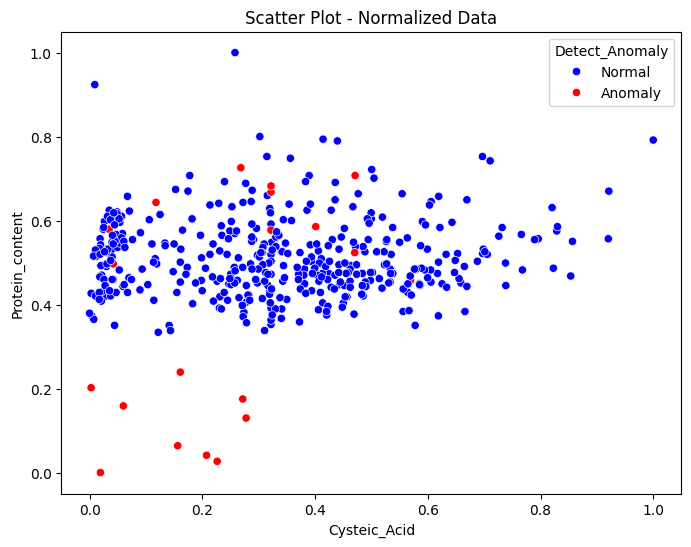

In [ ]:


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_scaled,
    x="Cysteic_Acid",
    y="Protein_content",
    hue="Detect_Anomaly",
    palette={"Normal":"blue","Anomaly":"red"}
)
plt.title("Scatter Plot - Normalized Data")
plt.show()


### HISTOGRAM

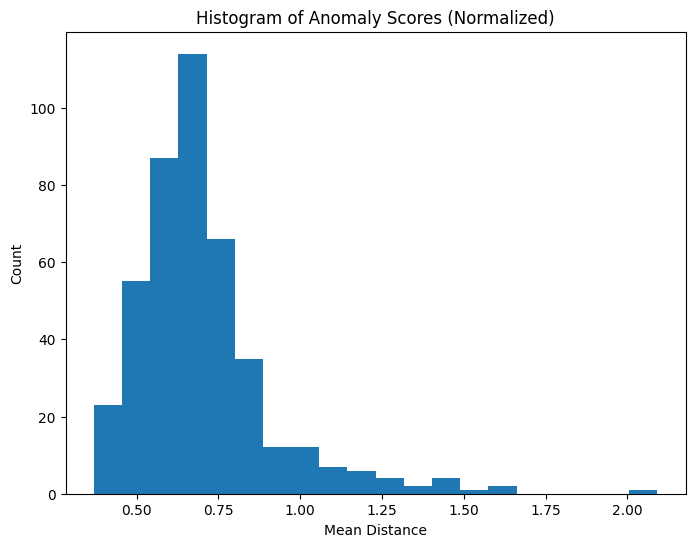

In [63]:
plt.figure(figsize=(8,6))
plt.hist(df_scaled["Mean_Distance"], bins=20)
plt.xlabel("Mean Distance")
plt.ylabel("Count")
plt.title("Histogram of Anomaly Scores (Normalized)")
plt.show()
